# DDQN Lunar Lander
Implementation of Double Deep Q-Network (DDQN) to solve the game Lunar Lander by earning more than +200 total reward on average over 100 trials.

In [1]:
# %pip install numpy==1.22.0
# %pip install gym==0.18.0
# %pip install tqdm==4.43.0
# %pip install matplotlib
# %brew install swig
# %pip install box2d-py
# %pip install PyOpenGL PyOpenGL_accelerate
# %pip install box2d box2d-kengz
# %pip install --upgrade git+http://github.com/pyglet/pyglet@pyglet-1.5-maintenance

In [2]:
import gym
from gym import wrappers

import os
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
CURR_PATH = os.path.abspath('')
OUTPUT_PATH = os.path.join(CURR_PATH, 'output')
RANDOM_AGENT_PATH = os.path.join(OUTPUT_PATH, 'random_agent')
DDQN_AGENT_PATH = os.path.join(OUTPUT_PATH, 'ddqn_agent')
DDQN_CHECKPOINT_PATH = os.path.join(DDQN_AGENT_PATH, 'policy_model_checkpoint.pth')
DDQN_RESULT_IMG_PATH = os.path.join(DDQN_AGENT_PATH, 'result_img_{}.png')
DDQN_VANILLA_RESULT_ARR_PATH = os.path.join(DDQN_AGENT_PATH, 'result_arr_vanilla_{}.txt')
DDQN_MEMORY_RESULT_ARR_PATH = os.path.join(DDQN_AGENT_PATH, 'result_arr_memory_{}_{}.txt')
DDQN_MEMORY_CHECKPOINT_PATH = os.path.join(DDQN_AGENT_PATH, 'policy_model_checkpoint_{}_{}.pth')

for p in [RANDOM_AGENT_PATH, DDQN_AGENT_PATH]: # add saving for other agents in here
    if not os.path.exists(p): 
        os.makedirs(p)

## Lunar Lander

In [4]:
env = gym.make('LunarLander-v2')
n_states, n_actions = env.observation_space.shape[0], env.action_space.n
# print('state space: {}'.format(n_states))
# print('action space: {}'.format(n_actions))

## Random Strategy

In [5]:
class RandomAgent(object):
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self):
        return self.action_space.sample()

# env = wrappers.Monitor(env, RANDOM_AGENT_PATH, force=True)
agent = RandomAgent(env.action_space)
ob = env.reset()
while True:
    action = agent.act()
    _, _, done, _, _ = env.step(action)
    if done:
        break
env.close()

## Double Deep Q-Network

### Model Graph

In [6]:
class DDQN_Graph(nn.Module): 
    def __init__(self, n_states, n_actions, hidden_size=32): 
        super(DDQN_Graph, self).__init__()
        self.n_actions = n_actions
        self.half_hidden_size = int(hidden_size/2)
        # hidden representation
        self.dense_layer_1 = nn.Linear(n_states, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        # V(s)
        self.v_layer_1 = nn.Linear(hidden_size, self.half_hidden_size)
        self.v_layer_2 = nn.Linear(self.half_hidden_size, 1)
        # A(s, a)
        self.a_layer_1 = nn.Linear(hidden_size, self.half_hidden_size)
        self.a_layer_2 = nn.Linear(self.half_hidden_size, n_actions)
        
    def forward(self, state):
        x = F.relu(self.dense_layer_1(state))
        x = F.relu(self.dense_layer_2(x))
        v = F.relu(self.v_layer_1(x))
        v = self.v_layer_2(v)
        a = F.relu(self.a_layer_1(x))
        a = self.a_layer_2(a)
        
        # Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
        return v + a - a.mean(dim=-1, keepdim=True).expand(-1, self.n_actions)

class DDQN_LSTM_Graph(nn.Module): 
    def __init__(self, n_states, n_actions, hidden_size=32): 
        super(DDQN_LSTM_Graph, self).__init__()
        self.n_actions = n_actions
        self.half_hidden_size = int(hidden_size/2)
        # hidden representation
        self.lstm_layer_1 = nn.Linear(n_states, hidden_size)
        self.lstm_layer_2 = nn.LSTM(hidden_size, hidden_size)
        # V(s)
        self.v_layer_1 = nn.Linear(hidden_size, self.half_hidden_size)
        self.v_layer_2 = nn.Linear(self.half_hidden_size, 1)
        # A(s, a)
        self.a_layer_1 = nn.Linear(hidden_size, self.half_hidden_size)
        self.a_layer_2 = nn.Linear(self.half_hidden_size, n_actions)
        
    def forward(self, state):
        x = F.relu(self.lstm_layer_1(state))
        x = F.relu(self.lstm_layer_2(x)[0])
        v = F.relu(self.v_layer_1(x))
        v = self.v_layer_2(v)
        a = F.relu(self.a_layer_1(x))
        a = self.a_layer_2(a)

        # Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
        return v + a - a.mean(dim=-1, keepdim=True).expand(-1, self.n_actions)

### Replay Memory

In [7]:
class ReplayMemory(): 
    """
    Replay memory records previous observations for the agent to learn later
    by sampling from the memory randomly
    """
    def __init__(self, capacity): 
        super(ReplayMemory, self).__init__() 
        self.capacity = capacity
        # to avoid empty memory list to insert transitions
        self.memory = [None] * capacity
        self.position = 0
        self.Transition = namedtuple('Transition', 
                                     ('state', 'action', 'reward', 'next_state', 'done'))
    
    def size(self):
        return len(self.memory) - self.memory.count(None)
    
    def push(self, *args):
        # save a transition at a certain position of the memory
        self.memory[self.position] = self.Transition(*args)        
        # update position
        self.position = (self.position + 1) % self.capacity
    
    def pull(self):
        return [exp for exp in self.memory if exp is not None]
    
    def sample(self, batch_size):
        exps = random.sample(self.pull(), batch_size)
        states = torch.tensor(np.vstack([e.state for e in exps if e is not None])).float()
        actions = torch.tensor(np.vstack([e.action for e in exps if e is not None])).long()
        rewards = torch.tensor(np.vstack([e.reward for e in exps if e is not None])).float()
        next_states = torch.tensor(np.vstack([e.next_state for e in exps if e is not None])).float()
        dones = torch.tensor(np.vstack([e.done for e in exps if e is not None]).astype(np.uint8)).float()
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

### Agent

In [8]:
class DDQN_Agent(): 
    """docstring for ddqn_agent"""
    def __init__(self, n_states, n_actions, batch_size, hidden_size, memory_size, 
                 update_step, learning_rate, gamma, tau, mode = "dense"):
        super(DDQN_Agent, self).__init__()
        # state space dimension
        self.n_states = n_states
        # action space dimension
        self.n_actions = n_actions
        # configuration
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.update_step = update_step
        self.lr = learning_rate
        self.gamma = gamma
        self.tau = tau
        # check cpu or gpu
        self.setup_gpu()
        # initialize model graph
        self.setup_model(mode)
        # initialize optimizer
        self.setup_opt()
        # enable Replay Memory
        self.memory = ReplayMemory(memory_size)
        # others
        self.prepare_train()
    
    def setup_gpu(self): 
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def setup_model(self, mode):
        if(mode == "dense"):
            self.policy_model = DDQN_Graph(
                self.n_states, 
                self.n_actions, 
                self.hidden_size).to(self.device)
            self.target_model = DDQN_Graph(
                self.n_states, 
                self.n_actions, 
                self.hidden_size).to(self.device)
        else:
            self.policy_model = DDQN_LSTM_Graph(
                self.n_states, 
                self.n_actions, 
                self.hidden_size).to(self.device)
            self.target_model = DDQN_LSTM_Graph(
                self.n_states, 
                self.n_actions, 
                self.hidden_size).to(self.device)

    def setup_opt(self):
        self.opt = torch.optim.Adam(self.policy_model.parameters(), lr=self.lr)
    
    def prepare_train(self):
        self.steps = 0
    
    def act(self, state, epsilon):
        # take an action for a time step
        # state: 1, state_size
        state = torch.tensor(state).reshape(1, -1).to(self.device)
        # print(state.shape)
        # inference by policy model
        self.policy_model.eval()
        with torch.no_grad(): 
            # action_vs: 1, action_size
            action_vs = self.policy_model(state)
        self.policy_model.train()
        # return action: 1
        # epsilon greedy search
        if np.random.random() > epsilon:
            return np.argmax(action_vs.cpu().detach().numpy())
        else:
            return np.random.randint(self.n_actions)
    
    def step(self, s, a, r, s_, done):
        # add one observation to memory
        self.memory.push(s, a, r, s_, done)
        # update model for every certain steps
        self.steps = (self.steps + 1) % self.update_step
        if self.steps == 0 and self.memory.size() >= self.batch_size:
            exps = self.memory.sample(self.batch_size)
            self.learn(exps)
        else:
            pass
    
    def learn(self, exps, soft_copy=True):
        
        for item in exps:
            item.to(self.device)
        # states: batch_size, state_size
        # actions: batch_size, 1
        # rewards: batch_size, 1
        # next_states: batch_size, state_size
        # dones: batch_size, 1
        states, actions, rewards, next_states, dones = exps
        # target side
        _, next_idx = self.policy_model(next_states).detach().max(1)
        # action values: batch_size, action_size
        target_next_action_vs = self.target_model(next_states).detach().gather(1, next_idx.unsqueeze(1))
        # Q values: batch_size, 1
        # Q = reward + (gamma * Q[next state][next action]) for not done
        target_q_vs = rewards + (self.gamma * target_next_action_vs * (1 - dones))
        # policy side
        # Q values: batch_size, 1
        policy_q_vs = self.policy_model(states).gather(1, actions)
        # compute MSE loss
        loss = F.mse_loss(policy_q_vs, target_q_vs)
        # update policy network
        self.opt.zero_grad()
        loss.backward()
        # gradient clamping
        for p in self.policy_model.parameters(): 
            p.grad.data.clamp_(-1, 1)
        self.opt.step()
        if soft_copy:
            # update target network via soft copy with ratio tau
            # θ_target = τ*θ_local + (1 - τ)*θ_target
            for tp, lp in zip(self.target_model.parameters(), self.policy_model.parameters()):
                tp.data.copy_(self.tau * lp.data + (1.0-self.tau) * tp.data)
        else:
            # update target network via hard copy
            self.target_model.load_state_dict(self.policy_model.state_dict())
        

### Training

In [9]:
# initial definition
batch_size = 64
hidden_size = 64
memory_size = int(1e5)
update_step = 4
learning_rate = 5e-4
gamma = 0.99
tau = 1e-2

n_episodes = 2000
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.004
rewards_window_size = 100

lambda_decay = 0.1

In [10]:
# initialize epsilon values for greedy search
epsilon_array = np.zeros((n_episodes))
for i in range(n_episodes):
    epsilon = min_epsilon + (max_epsilon-min_epsilon)*np.exp(-decay_rate*i)
    epsilon_array[i] = epsilon

# plt.plot(epsilon_array)

# plt.ylabel('Epsilon', fontsize=12)
# plt.xlabel('Episode', fontsize=12)
# plt.show()

In [11]:
# training process
# initialize the DDQN agent given a configuration
from re import S

# agent = DDQN_Agent(n_states, 
#                    n_actions, 
#                    batch_size, 
#                    hidden_size, 
#                    memory_size, 
#                    update_step, 
#                    learning_rate, 
#                    gamma, 
#                    tau,
#                    "dense")

def ddqn_learn_op(agent, n_episodes, rewards_window_size, epsilon_array, lambda_decay, verbose = True, indx = 0):
    best_avg_rewards = -np.inf
    total_rewards = []
    rewards_deque = deque(maxlen=rewards_window_size)
    t = trange(n_episodes) if verbose else range(n_episodes)
    cur_state = np.zeros(n_states)
    for episode in t:
        # initialize the 
        cur_state_mem = [(lambda_decay * x + (1 - lambda_decay) * y).astype(np.float32) for x, y in zip(cur_state, env.reset()[0])]
        done = False
        rewards = 0
        epsilon = epsilon_array[episode]
        steps = 0
        while not done:
            action = agent.act(cur_state_mem, epsilon)
            s = env.step(action)
            next_state, reward, done, trunc, _ = s
            done = done or trunc
            # cur_state = next_state
            next_state_mem = [(lambda_decay * x + (1 - lambda_decay) * y).astype(np.float32) for x, y in zip(cur_state_mem, next_state)]
            agent.step(cur_state_mem, action, reward, next_state_mem, done)
            cur_state_mem = next_state_mem
            rewards += reward
            steps += 1
            # print(done)
            # stop
        # update information
        total_rewards.append(rewards)
        rewards_deque.append(rewards)
        avg_rewards = np.mean(rewards_deque)
        if(verbose):
            t.set_description(
            'Episode {} Epsilon {:.2f} Reward {:.2f} Avg_Reward {:.2f} Best_Avg_Reward {:.2f} Steps {}'.format(
                episode + 1, epsilon, rewards, avg_rewards, best_avg_rewards, steps))
            t.refresh()
        # evaluation
        # if avg_rewards >= best_avg_rewards: 
        #     best_avg_rewards = avg_rewards
            # torch.save(agent.policy_model.state_dict(), DDQN_CHECKPOINT_PATH)
        # the game is solved by earning more than +200 rewards for a single episode
        # if best_avg_rewards > 200:
        #     break
        if avg_rewards >= best_avg_rewards: 
            best_avg_rewards = avg_rewards
        if avg_rewards > 200: 
            torch.save(agent.policy_model.state_dict(), DDQN_MEMORY_CHECKPOINT_PATH.format(lambda_decay, indx))
    return total_rewards, rewards_deque

In [21]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except (ValueError, msg):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

/var/folders/_3/xv_6fqg10f37htlymzdl0gl00000gn/T/ipykernel_28132/2357268312.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_rewards(np.array([np.loadtxt(DDQN_MEMORY_RESULT_ARR_PATH.format(lambda_decay, i), dtype=int) for i in range(count)]), "Memory Trace {}".format(lambda_decay))
/var/folders/_3/xv_6fqg10f37htlymzdl0gl00000gn/T/ipykernel_28132/4206349787.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for mor

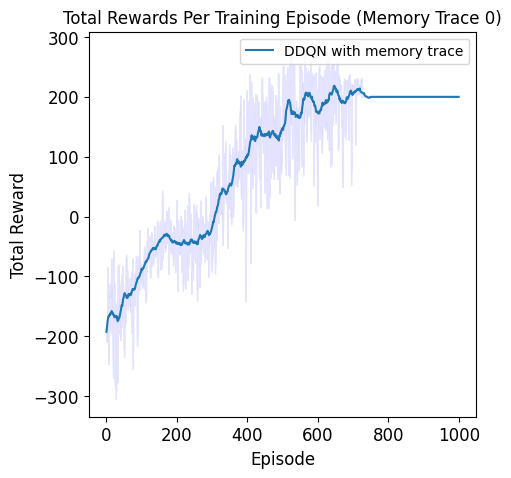

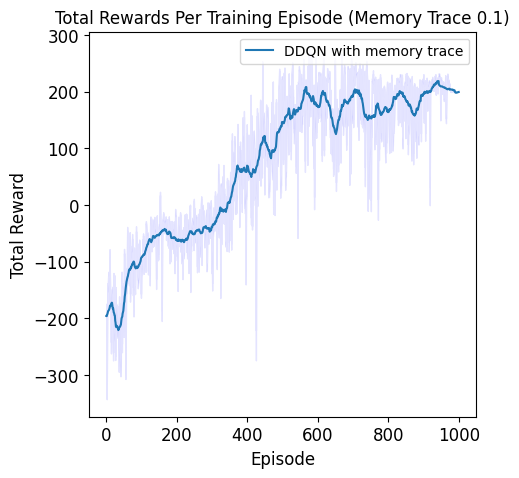

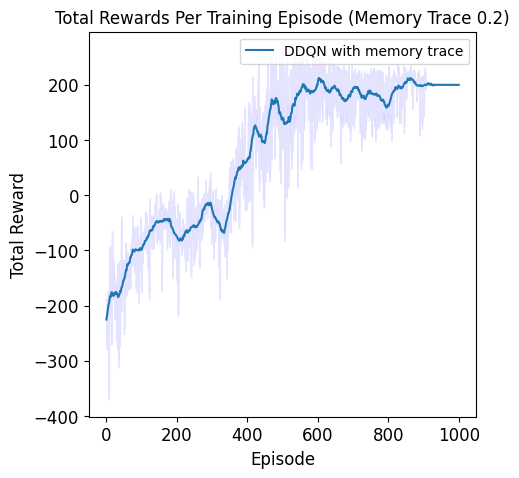

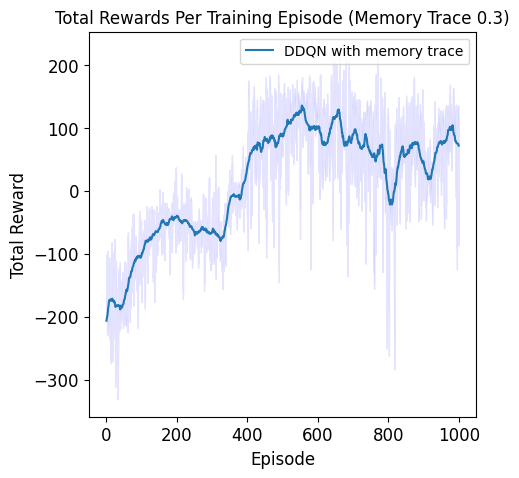

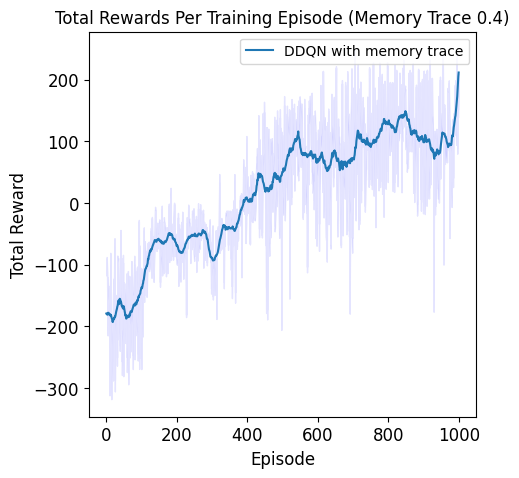

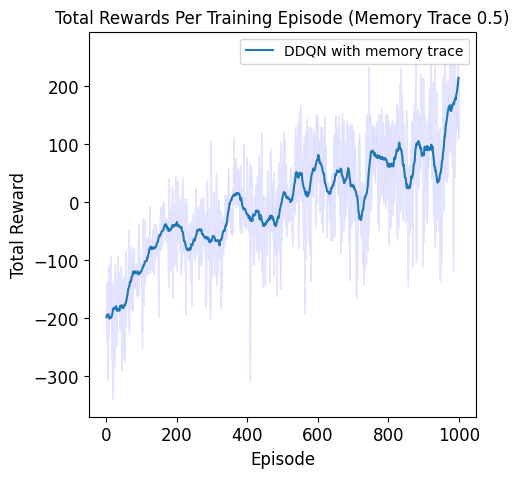

In [23]:
def plot_rewards(train_rewards, title):
    expanded_train_rewards = np.array([rew if len(rew) >= n_episodes else np.concatenate((rew, np.repeat(200, n_episodes - len(rew)))) for rew in train_rewards])
    # p1_e = np.array([rew if len(rew) >= n_episodes else np.concatenate((rew, np.repeat(200, n_episodes - len(rew)))) for rew in p1])
    plt.subplots(figsize = (5, 5), dpi=100)
    y = np.mean(expanded_train_rewards, axis=0)
    # p = np.mean(p1_e, axis=0)
    ci = 1.96 * np.std(expanded_train_rewards, axis=0)/np.sqrt(len(expanded_train_rewards[0]))
    # ci2 = 1.96 * np.std(p1_e, axis=0)/np.sqrt(len(p1_e[0]))
    # plt.plot(range(len(expanded_train_rewards[0])), p, label='vanilla DDQN')
    yhat = savitzky_golay(y, 51, 3)
    plt.plot(range(len(expanded_train_rewards[0])), yhat, label='DDQN with memory trace')
    plt.fill_between(np.arange(0, len(expanded_train_rewards[0]), 1), (y-ci), (y+ci), color='b', alpha=.1)
    # plt.fill_between(range(len(expanded_train_rewards[0])), (p-ci2), (p+ci2), color='orange', alpha=.1)

    plt.ylabel('Total Reward', fontsize=12)
    plt.xlabel('Episode', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Total Rewards Per Training Episode ('+title+')', fontsize=12)
    plt.legend()
    plt.savefig(DDQN_RESULT_IMG_PATH.format(title), dpi=100, bbox_inches='tight')
    plt.show()

def plot_saved(count):
    # plot_rewards(np.array([np.loadtxt(DDQN_VANILLA_RESULT_ARR_PATH.format(i), dtype=int) for i in range(count)]), "Vanilla")
    # plot_rewards(np.array([np.loadtxt(DDQN_MEMORY_RESULT_ARR_PATH.format(i), dtype=int) for i in range(count)]), "Memory Trace")
    for lambda_decay in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
        plot_rewards(np.array([np.loadtxt(DDQN_MEMORY_RESULT_ARR_PATH.format(lambda_decay, i), dtype=int) for i in range(count)]), "Memory Trace {}".format(lambda_decay))



# plot_rewards(np.array([np.loadtxt(DDQN_VANILLA_RESULT_ARR_PATH.format(i), dtype=int) for i in range(20)]), np.array([np.loadtxt(DDQN_MEMORY_RESULT_ARR_PATH.format(i), dtype=int) for i in range(20)]), "Memory Trace")
plot_saved(3)

### Serial

In [22]:
# train_results = [[],[]]
for lambda_decay in [0.1, 0.2, 0.3, 0.4, 0.5]:
    for i in range(3):
        print(lambda_decay, i)
        res = ddqn_learn_op(DDQN_Agent(n_states, 
                    n_actions, 
                    batch_size, 
                    hidden_size, 
                    memory_size, 
                    update_step, 
                    learning_rate, 
                    gamma, 
                    tau,
                    "dense"), n_episodes, rewards_window_size, epsilon_array, lambda_decay, False, i)[0]
        
        # np.savetxt((DDQN_VANILLA_RESULT_ARR_PATH if lambda_decay == 0 else DDQN_MEMORY_RESULT_ARR_PATH).format(i), np.array(res), fmt='%d')
        np.savetxt(DDQN_MEMORY_RESULT_ARR_PATH.format(lambda_decay, i), np.array(res), fmt='%d')
        # train_results[0 if lambda_decay == 0 else 1].append(res)
    # train_rewards = np.array([ddqn_learn_op(DDQN_Agent(n_states, 
    #                n_actions, 
    #                batch_size, 
    #                hidden_size, 
    #                memory_size, 
    #                update_step, 
    #                learning_rate, 
    #                gamma, 
    #                tau,
    #                "dense"), n_episodes, rewards_window_size, epsilon_array)[0] for _ in range(20)])
    # plot_rewards(train_rewards, "Vanilla" if lambda_decay == 0 else "Memory Trace")
    # train_results[i].append(train_rewards)

    # np.savetxt('test1.txt', a, fmt='%d')
    # b = np.loadtxt('test1.txt', dtype=int)
    

0.1 0
0.1 1
0.1 2
0.2 0
0.2 1
0.2 2
0.3 0
0.3 1
0.3 2
0.4 0
0.4 1
0.4 2
0.5 0
0.5 1
0.5 2


/var/folders/_3/xv_6fqg10f37htlymzdl0gl00000gn/T/ipykernel_52222/208342257.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_rewards(np.array([np.loadtxt(DDQN_VANILLA_RESULT_ARR_PATH.format(i), dtype=int) for i in range(count)]), "Vanilla")


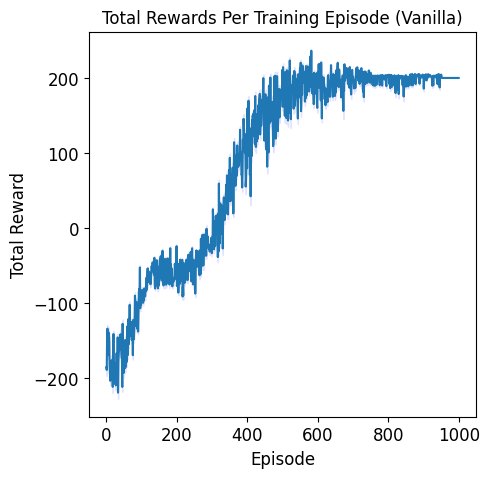

/var/folders/_3/xv_6fqg10f37htlymzdl0gl00000gn/T/ipykernel_52222/208342257.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_rewards(np.array([np.loadtxt(DDQN_MEMORY_RESULT_ARR_PATH.format(i), dtype=int) for i in range(count)]), "Memory Trace")


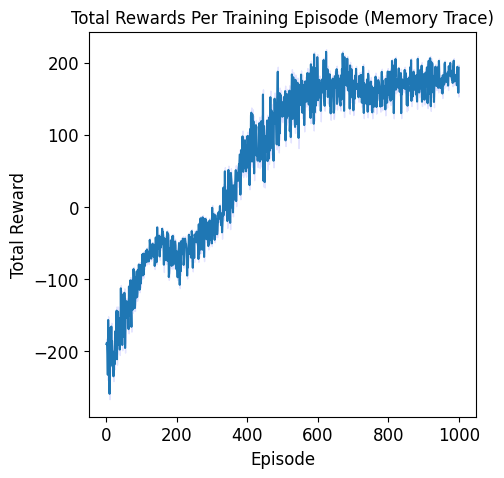

In [13]:
plot_saved(20)

### Prallel

In [ ]:
import threading

train_results = []
for i in range(2): train_results.append([])

exitFlag = 0

class myThread (threading.Thread):
     def __init__(self, name, results_array, count, lambda_dec, on_finish):
          threading.Thread.__init__(self)
          self.name = name
          self.results_array = results_array
          self.count = count
          self.lambda_dec = lambda_dec
          self.on_finish = on_finish
     def run(self):
          print("Starting " + self.name)
          
          train_rewards = np.array([ddqn_learn_op(DDQN_Agent(n_states, 
               n_actions, 
               batch_size, 
               hidden_size, 
               memory_size, 
               update_step, 
               learning_rate, 
               gamma, 
               tau,
               "dense"), n_episodes, rewards_window_size, epsilon_array, self.lambda_dec, False)[0] for _ in range(self.count)])     

          for t in train_rewards: self.results_array[0 if self.lambda_dec == 0 else 1].append(t)
          print("Exiting " + self.name)
          if((len(self.results_array[0]) + len(self.results_array[1])) == count * 4):
               self.on_finish()


def plot_train(res):
    plot_rewards(res[0], "Vanilla")
    plot_rewards(res[1], "Memory Trace")
    
# Create new threads
count = 1
thread1 = myThread("Thread-1", train_results, count, 0, lambda: plot_train(train_results))
thread2 = myThread("Thread-2", train_results, count, 0, lambda: plot_train(train_results))
thread3 = myThread("Thread-3", train_results, count, 0, lambda: plot_train(train_results))
thread4 = myThread("Thread-4", train_results, count, 0, lambda: plot_train(train_results))
thread5 = myThread("Thread-5", train_results, count, 0.1, lambda: plot_train(train_results))
thread6 = myThread("Thread-6", train_results, count, 0.1, lambda: plot_train(train_results))
thread7 = myThread("Thread-7", train_results, count, 0.1, lambda: plot_train(train_results))
thread8 = myThread("Thread-8", train_results, count, 0.1, lambda: plot_train(train_results))

# Start new Threads
thread1.start()
thread2.start()
thread3.start()
thread4.start()
thread5.start()
thread6.start()
thread7.start()
thread8.start()

### Results

In [ ]:
plot_train(train_results)

### Evaluation

In [ ]:
# test_episodes=100
# test_reward_array = np.zeros(100)
# agent = DDQN_Agent(n_states, 
#                    n_actions, 
#                    batch_size, 
#                    hidden_size, 
#                    memory_size, 
#                    update_step, 
#                    learning_rate, 
#                    gamma, 
#                    tau)
# # load check point to restore the model
# agent.policy_model.load_state_dict(
#     torch.load(DDQN_CHECKPOINT_PATH, map_location=agent.device))

# t = trange(test_episodes, leave=True)
# for episode in t: 
#     state = env.reset()[0]
#     done = False
#     rewards = 0. 
#     while not done: 
#         # disable epsilon greedy search
#         action = agent.act(state, epsilon=0) 
#         state, reward, done, _, _ = env.step(action)
#         rewards += reward
#     t.set_description('Episode {:.2f} Reward {:.2f}'.format(episode + 1, rewards))
#     t.refresh()
#     test_reward_array[episode] = rewards
# env.close()

In [ ]:
# avg_test_reward = round(np.mean(test_reward_array), 2)
# plt.subplots(figsize = (5, 5), dpi=100)
# plt.plot(test_reward_array)
# plt.ylabel('Total Reward', fontsize=12)
# plt.xlabel('Trial', fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.title('Total Rewards Per Trial for 100 Trials - Average: {:.2f}'.format(avg_test_reward), 
#           fontsize=12)
# # plt.savefig(DDQN_RESULT_IMG_PATH.format(1), dpi=100, bbox_inches='tight')
# plt.show()

## Reference

1. Hasselt, H. V. (2010). Double Q-learning. In Advances in neural information processing systems (pp. 2613-2621).
2. Van Hasselt, H., Guez, A., & Silver, D. (2016, March). Deep reinforcement learning with double q-learning. In Thirtieth AAAI conference on artificial intelligence.
3. Brockman, G., Cheung, V., Pettersson, L., Schneider, J., Schulman, J., Tang, J., & Zaremba, W. (2016). Openai gym. arXiv preprint arXiv:1606.01540.

In [ ]:
# env = gym.make('LunarLander-v2', render_mode="rgb_array")


# agent = DDQN_Agent(n_states, 
#                    n_actions, 
#                    batch_size, 
#                    hidden_size, 
#                    memory_size, 
#                    update_step, 
#                    learning_rate, 
#                    gamma, 
#                    tau)
# # load check point to restore the model
# agent.policy_model.load_state_dict(
#     torch.load(DDQN_CHECKPOINT_PATH, map_location=agent.device))
    
# total_reward = 0.0
# total_steps = 0
# obs = env.reset()

# while True:
#     action = agent.act(state, epsilon=0)
#     obs, reward, done, _, _ = env.step(action)
#     total_reward += reward
#     total_steps += 1
#     env.render()
#     if done:
#         break

# print("Episode done in %d steps, total reward %.2f.\nSaved recording to %s" % (
#     total_steps, total_reward, DDQN_RESULT_IMG_PATH))
# env.close()
# env.env.close()